### darcy_3d

Use darcy law, build 4 PINN, a reproduction of paper [J. D. Toscano et al. 2025](https://doi.org/10.1101/2025.07.30.667741)

0. parameter adjust

In [3]:
do_training = True
# if do not training, please provide pth path to load.
ckpt_path = "data/adpinn_pde_v_32_20-52_l8_n128_20250930.pth"

continue_training = True
# if continue training, please provide ckpt path to load.
# ckpt_path = "data/adpinn_init_c_32_20-52_l8_n128_20250930.pth"

neuron_num = 128
hid_layer_num = 8

position_encode_freq_scale = 1.0

train_setting = {
    "init_c":{
        "learning_rate": 5e-4,
        "max_epochs": 5000,
    },
    "init_v":{
        "learning_rate": 5e-4,
        "max_epochs": 5000,
    },
    "pde_v":{
        "learning_rate": 1e-4,
        "max_epochs": 5000,
    },
    # "joint":{
    #     "learning_rate": 1e-5,
    #     "max_epochs": 2000,
    # }
}


1. Data preparation

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import lightning as L
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import TensorBoardLogger

from ad_net import AD_Net
from datetime import datetime

%matplotlib widget
%load_ext autoreload
%autoreload 2


In [5]:
from data_module import load_dcemri_data, CharacteristicDomain, DCEMRIDataModule, VelocityDataModule
from visualize import visualize_prediction_vs_groundtruth, draw_nifti_slices_with_time, draw_nifti_slices_with_threshold

data,mask,pixdim,x,y,z,t = load_dcemri_data("data/dataset_downsampled.npz")

# Also need to transform anisotropic diffusivity if needed here.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

char_domain = CharacteristicDomain(data.shape, t, pixdim, device)

print("L_star: ",char_domain.L_star, "T_star: ", char_domain.T_star ,
      "Pe_g: ", char_domain.Pe_g)
# batch_size is sum over data's point
c_dataset = DCEMRIDataModule(data, char_domain, mask, 
                           batch_size=int(mask.sum()*len(t)), device=device)

data_shape:  (32, 40, 32, 18) pixdim:  [0.5 0.5 0.5]
domain_shape:  (32,) (40,) (32,) (18,)
min_c:  0.0 max_c:  299.53845
L_star:  [7.75 9.75 7.75] T_star:  34.0 Pe_g:  20835.375816993463


In [6]:
# use front-tracking to get initial velocity field.
from front_tracking import front_tracking_velocity
# shape (nx, ny, nz, 3), only use half of the timestep to training, consistant with c_dataset

initial_velocity_field = front_tracking_velocity(data[:,:,:,::2], 
                                                 dt=t[2] - t[0])
# scaling using V_star
initial_velocity_field /= char_domain.V_star
# draw initial velocity magnitude
vel_mag = np.linalg.norm(initial_velocity_field, axis=-1)

# print(pixdim, char_domain.domain_shape, char_domain.L_star, char_domain.T_star, char_domain.V_star)
print("velocity max and min: ", vel_mag.max(), vel_mag.min())

draw_nifti_slices_with_threshold(vel_mag)

v_dataset = VelocityDataModule(initial_velocity_field, char_domain, mask, 
                              batch_size=int(mask.sum()), device=device)

velocity max and min:  1.627875979102795 0.0
Volume shape: (32, 40, 32) dtype: float64


interactive(children=(IntSlider(value=16, description='z', max=31), FloatSlider(value=0.5, description='thr', …

2. Network definition

Here only define a base advect-diffuse PINN that learn the whole, it is reported in [J. D. Toscano et al. 2025](https://doi.org/10.1101/2025.07.30.667741) , that pure AD instead of Darcy's law cannot capture bimodal velocity distribution. 

This version has two variants:
1. simply using FNN to produce velocity field, without any pruning on solution space.
2. physics constrained divergence-free to the 


In [7]:
class ADPINN_Base(L.LightningModule):
    def __init__(self, ad_net: AD_Net, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters({"learning_rate": learning_rate})

        self.L2_loss = nn.MSELoss()

        self.ad_net = ad_net
        self.c_net = ad_net.c_net
        self.v_net = ad_net.v_net
        
        self.learning_rate = learning_rate
        
        # slice domain for visualization
        self.val_slice_z = [data.shape[2]//4, data.shape[2]//2, 3*data.shape[2]//4]
        self.val_slice_t = [data.shape[3]//4, data.shape[3]//2, 3*data.shape[3]//4]
        self.val_slice_4d = char_domain.get_characteristic_geotimedomain(slice_zindex = self.val_slice_z, 
                                                                       slice_tindex = self.val_slice_t)
        Z,T = np.meshgrid(self.val_slice_z, self.val_slice_t, indexing='ij')
        self.val_slice_gt_c = data[:, :, Z, T] / c_dataset.C_star # simulate the dataset process
        # print(self.val_slice_gt_c.shape)
    
    
    def configure_optimizers(self):
        params = [p for p in self.parameters() if p.requires_grad]
        optimizer = torch.optim.AdamW(params, lr=self.learning_rate, weight_decay=1e-6)
        return optimizer
    
    def validation_step(self, batch, batch_idx):
        x, C_true = batch
        C_pred = self.c_net(x)
        mse_data = self.L2_loss(C_pred, C_true)
        
        # also slice c map of mid time + mid z when validation
        if batch_idx == 0:
            self.log('val_data_loss', mse_data)
            if self.current_epoch % 50 == 0:
                self.draw_concentration_slices()
                self.draw_velocity_slices()
        return mse_data
    
    def draw_concentration_slices(self, to_logger=True):
        with torch.no_grad():
            vol_disp_all = self.c_net(self.val_slice_4d).cpu().numpy().reshape(
                data.shape[0], data.shape[1], len(self.val_slice_z), len(self.val_slice_t))
            # self.logger.experiment.add_image('val_C_slice', vol_disp, self.current_epoch, dataformats='HW')
            # scale of vol_disp will done inside visualize function
            c_vis_list = []
            for i in range(len(self.val_slice_z)):
                for j in range(len(self.val_slice_t)):
                    slice_gt_c = self.val_slice_gt_c[:, :, i, j]
                    vol_disp = vol_disp_all[:, :, i, j]
                    vol_disp *= mask[:,:,self.val_slice_z[i]]  # mask out of brain region
                    c_vis_list.append(visualize_prediction_vs_groundtruth(vol_disp, slice_gt_c))
            # stack all images horizontally (along H direction)
            c_vis_list = np.hstack(c_vis_list)
            if to_logger:
                self.logger.experiment.add_image('val_C_compare', c_vis_list, self.current_epoch, dataformats='WH')
            else:
                plt.figure(figsize=(6,3))
                plt.imshow(c_vis_list, cmap='jet', vmin=0, vmax=1)
                plt.axis('off')
                plt.show()


    def draw_velocity_slices(self):
        with torch.no_grad():
            vx_img, vy_img, vz_img = self.v_net(self.val_slice_4d)
            vx_img = vx_img.cpu().numpy().reshape(data.shape[0], data.shape[1], len(self.val_slice_z), len(self.val_slice_t))
            vy_img = vy_img.cpu().numpy().reshape(data.shape[0], data.shape[1], len(self.val_slice_z), len(self.val_slice_t))
            vz_img = vz_img.cpu().numpy().reshape(data.shape[0], data.shape[1], len(self.val_slice_z), len(self.val_slice_t))
            v_vis_list = []
            for i in range(len(self.val_slice_z)):
                for j in range(len(self.val_slice_t)):
                    vx = vx_img[:, :, i, j]
                    vy = vy_img[:, :, i, j]
                    vz = vz_img[:, :, i, j]
                    v_vis_list.append(vx ** 2 + vy ** 2 + vz ** 2)
            v_vis_list = np.hstack(v_vis_list)
            # scale to [0,1] for visualization
            v_vis_list = (v_vis_list - v_vis_list.min()) / (v_vis_list.max() - v_vis_list.min() + 1e-8)
            self.logger.experiment.add_image('train_v_mag_slice', v_vis_list, self.current_epoch, dataformats='WH')


In [8]:
# Training variant 1: init C_Net
class ADPINN_InitC(ADPINN_Base):
    def training_step(self, batch, batch_idx):
        x, C_true = batch
        C_pred = self.c_net(x)
        mse_data = self.L2_loss(C_pred, C_true)
        if batch_idx == 0:
            self.log('train_c_init_loss', mse_data)
        return mse_data

# Training varient 2: init V_Net (need heuristic estimate)
class ADPINN_InitV(ADPINN_Base):
    def training_step(self, batch_v, batch_idx):
        x, v_true = batch_v # still x shaped (N, 4), v_true shaped (N, 3)
        vx,vy,vz = self.v_net(x)
        vx = vx.view(vx.shape[0], -1) # (N, 1) -> (N, )
        vy = vy.view(vy.shape[0], -1)
        vz = vz.view(vz.shape[0], -1)
        v_pred = torch.cat([vx, vy, vz], dim=1) # (N, 3)

        mse_data = self.L2_loss(v_pred, v_true)

        if batch_idx == 0:
            self.log('train_v_init_loss', mse_data)
            if self.current_epoch % 50 == 0:
                self.draw_velocity_slices()
        return mse_data

# only optimize v + D, using advect-diffuse.
class ADPINN_PDE_V(ADPINN_Base):
    def __init__(self, ad_net, learning_rate=1e-3):
        super().__init__(ad_net, learning_rate)
        # freeze c_net
        for param in self.c_net.parameters():
            param.requires_grad = False
        self.c_net.eval()
        
    # TODO: here to batch could use smart sampling.
    def training_step(self, batch, batch_idx):
        x, _ = batch
        # PDE loss
        pde_residual = self.ad_net.pde_residual(x)
        mse_pde = self.L2_loss(pde_residual, torch.zeros_like(pde_residual))
        
        loss = mse_pde
        
        if batch_idx == 0:
            self.log('pde_v_residual', mse_pde)
            self.log('pde_v_D', self.ad_net.D.item())

        
        return loss

# joint optimize c + v + D, using advect-diffuse
class ADPINN_Joint(ADPINN_Base):
    def training_step(self, batch, batch_idx):
        x, C_true = batch
        C_pred = self.c_net(x)
        mse_data = self.L2_loss(C_pred, C_true)
        
        # PDE loss
        pde_residual = self.ad_net.pde_residual(x)
        mse_pde = self.L2_loss(pde_residual, torch.zeros_like(pde_residual))
        
        loss = mse_data + mse_pde

        if batch_idx == 0:
            self.log('joint_data_loss', mse_data)
            self.log('joint_pde_loss', mse_pde)
            self.log('joint_D', self.ad_net.D.item())
        
        return loss

3. Training step

- first we has initializaiton for c and v net
- then pde loss for only v net
- finally joint optimization.

In [ ]:
# Instantiate the model and trainer or load from checkpoint:
ad_net = AD_Net(c_layers=[4] + [neuron_num for _ in range(hid_layer_num)] + [1],
    u_layers=[3] + [neuron_num for _ in range(hid_layer_num)] + [3],
    incompressible=False,
    char_domain=char_domain,
    gamma_space=position_encode_freq_scale)

if do_training:
    if continue_training:
        checkpoint = torch.load(ckpt_path)
        ad_net.load_state_dict(checkpoint['state_dict'], strict=False)
    logger = TensorBoardLogger("tb_logs", name="seqtrain_ADPINN")

    trainer = Trainer(log_every_n_steps=3, gradient_clip_val=1.0, logger=logger)

    # define ordered phases explicitly
    phase_order = ["init_c", "init_v", "pde_v" ,"joint"]
    last_model = None
    total_epochs = 0
    
    for phase in phase_order:
        cfg = train_setting.get(phase)
        if not cfg:
            continue
        lr = cfg.get("learning_rate", 1e-3)
        max_epochs = cfg.get("max_epochs", 1000)

        if phase == "init_c":
            pinn_model = ADPINN_InitC(ad_net, learning_rate=lr)
            datamodule = c_dataset
        elif phase == "init_v":
            pinn_model = ADPINN_InitV(ad_net, learning_rate=lr)
            datamodule = v_dataset
        elif phase == "pde_v":
            pinn_model = ADPINN_PDE_V(ad_net, learning_rate=lr)
            datamodule = c_dataset
        elif phase == "joint":
            pinn_model = ADPINN_Joint(ad_net, learning_rate=lr)
            datamodule = c_dataset
        else:
            continue

        # update epochs per phase on the same Trainer
        total_epochs += max_epochs
        trainer.fit_loop.max_epochs = total_epochs

        # optional: tag phase in TensorBoard
        trainer.logger.experiment.add_text("phase/start", phase, global_step=trainer.global_step)
        # pinn_model.log = lambda name, value, **kw: super(type(pinn_model), pinn_model).log(f"{phase}/{name}", value, **kw)
        trainer.fit(pinn_model, datamodule=datamodule)
        
        trainer.save_checkpoint(f"data/adpinn_{phase}_{data.shape[0]}_{int(t[0])}-{int(t[-1])}_l{hid_layer_num}_n{neuron_num}_{datetime.now().strftime('%Y%m%d')}.pth")
        last_model = pinn_model
    
    pinn_model = last_model
else:
    if continue_training:
        checkpoint = torch.load(ckpt_path)
        ad_net.load_state_dict(checkpoint, strict=False)
    pinn_model = ADPINN_Joint(ad_net)


# After training, visualize the learned velocity field and diffusivity

# Extract learned parameters

D_learned = pinn_model.ad_net.D.item()

print(f"Learned diffusivity D: {D_learned}")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | L2_loss | MSELoss | 0      | train
1 | ad_net  | AD_Net  | 249 K  | train
2 | c_net   | C_Net   | 124 K  | train
3 | v_net   | V_Net   | 124 K  | train
---------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

w:\bigTool\Anaconda\envs\AI\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
w:\bigTool\Anaconda\envs\AI\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
w:\bigTool\Anaconda\envs\AI\lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=3). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:

# 1. Extract learned velocity field on a grid for visualization
pinn_model.to(device)

# use a grid (from real to characteristic) to extract velocity field
# Create a grid in normalized coordinates
nx, ny, nz = data.shape[0], data.shape[1], data.shape[2]
# to characteristic units first.
grid_tensor = char_domain.get_characteristic_geodomain()  # only need spatial part
print(grid_tensor.shape)
# directly using 3D matplotlib to visualize the quiver
with torch.no_grad():
    vx, vy, vz = pinn_model.v_net(grid_tensor)
    
    vx = vx.cpu().numpy().reshape((nx, ny, nz))
    vy = vy.cpu().numpy().reshape((nx, ny, nz))
    vz = vz.cpu().numpy().reshape((nx, ny, nz))
# Scale velocity back to physical units (mm/min)
vx *= char_domain.V_star[0]
vy *= char_domain.V_star[1]
vz *= char_domain.V_star[2]

torch.Size([40960, 3])


[0.5 0.5 0.5] (32, 40, 32) 0.1777172 -0.2967756


interactive(children=(IntSlider(value=3, description='Stride', max=10, min=1), IntSlider(value=25, description…

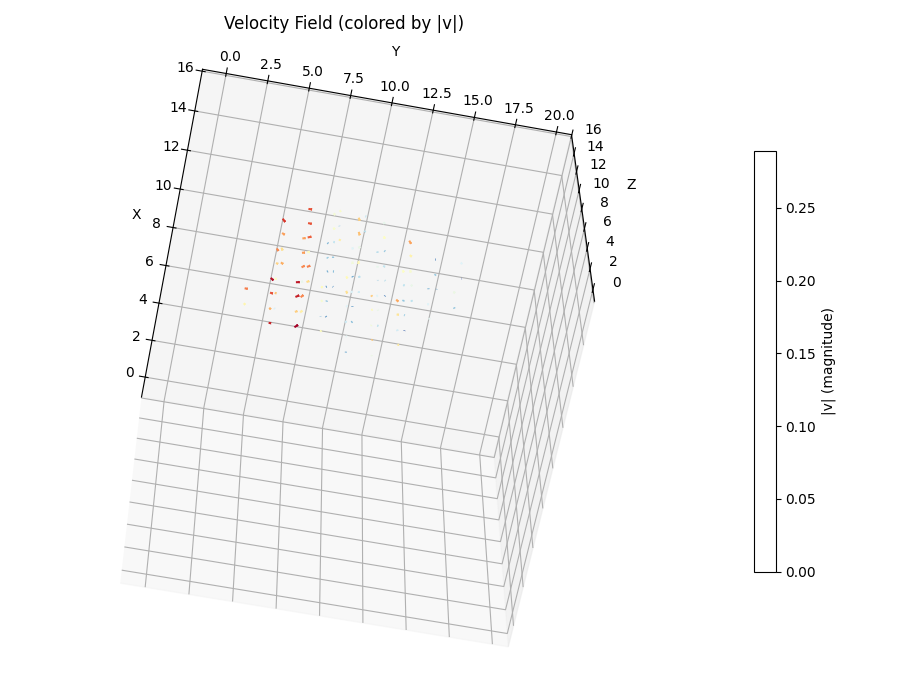

In [ ]:
%matplotlib widget

from visualize import draw_3d_quiver, interactive_quiver
# draw_3d_quiver(X, Y, Z, vx, vy, vz, stride=4)
# using mask to filter out the background vectors

# get rid of background vectors by mask
vx = vx * mask
vy = vy * mask
vz = vz * mask
print(pixdim, vx.shape, vx.max(), vx.min())
_ = interactive_quiver(vx, vy, vz, pixdim, default_elev=-62.76, default_azim=-10.87)


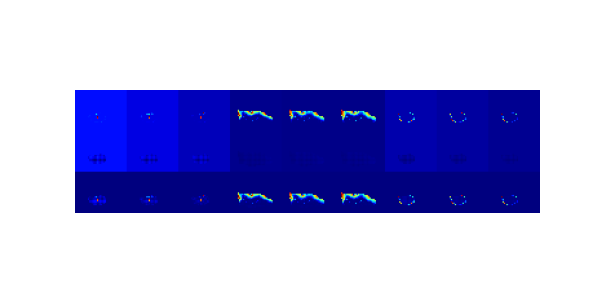

In [ ]:
# use pinn_model.val_slice_4d to draw concentration slices
pinn_model.draw_concentration_slices(to_logger=False)

torch.Size([368640, 4])
Pred shape: (32, 40, 32, 9) True shape: (32, 40, 32, 9)


Overall MSE: 40.86216735839844


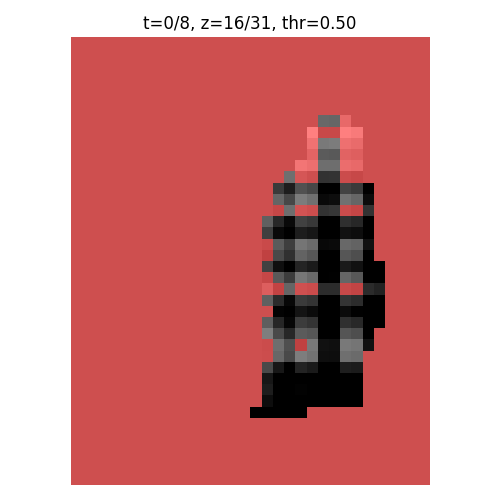

In [ ]:
# 2. Extract all density field with x,y,z,t 4D grid for visualization

grid_tensor_4d = char_domain.get_characteristic_geotimedomain()  # include time part
print(grid_tensor_4d.shape)
def predict_concentration_4d(model, pts4, nx, ny, nz, nt, batch_size=200_000):
    out_list = []
    with torch.no_grad():
        for i in range(0, pts4.shape[0], batch_size):
            chunk = pts4[i:i+batch_size]
            pred = model.c_net(chunk)
            out_list.append(pred.cpu())
    C_flat = torch.cat(out_list, dim=0).numpy().reshape(nx, ny, nz, nt)
    # C_flat = torch.cat(out_list, dim=0).numpy().reshape(nx, ny, nz, nt)
    return C_flat

C_pred_4d = predict_concentration_4d(pinn_model, grid_tensor_4d, nx, ny, nz, len(t), batch_size=200_000)

# Back to physical units
C_pred_4d *= c_dataset.C_star

print("Pred shape:", C_pred_4d.shape, "True shape:", data.shape)  # (nx, ny, nz, nt)

_ = draw_nifti_slices_with_time(C_pred_4d, mask)
# try calculate loss with true data
from sklearn.metrics import mean_squared_error
mse_overall = mean_squared_error(data.flatten(), C_pred_4d.flatten())

print(f"Overall MSE: {mse_overall}")

In [ ]:
# Export velocity to .mat format so that we could run GLAD using matlab
import scipy.io as sio
# the rOMT code require velocity reshaped to N*3 x 1

v_tensor = np.stack([vx.flatten(), vy.flatten(), vz.flatten()], axis=1)  # shape (N, 3)
v_tensor = v_tensor.reshape(-1, 1)  # shape (N*3, 1)
# repeated 4 times, as in rOMT there are 4 interpolate steps
v_tensor = np.tile(v_tensor, (4, 1))
print(v_tensor.shape)
sio.savemat("data/ad_net_velocity.mat", {"u": v_tensor, "pixdim": pixdim})


(491520, 1)
